# CNN para clasificar espectogramas de guitarra y distinguir si es un acorde o una nota
El siguiente notebook tiene como objetivo crear un modelo CNN de clasificación binaria que permita clasificar si un espectograma es una nota o un acorde

Para ello utilizaremos:
* TensorFlow
* Un dataset propio grabado con 3 guitarras acústicas (una parlor, otra electroacústica y otra acústica).
* Una libreria propia en python con funciones "helpers" que contiene funciones reutilizables que utilizaremos en los diferentes notebooks de este proyecto:

El dataset contiene dos carpetas (train y test):
* **train**: La utilizaremos para entrenar el módelo. Ha sido grabado con una guitarra parlor y otra acústica.
* **test**: La utilizaremos para validar y testear el módelo. Ha sido grabado con una guitarra electroacústica.

Partiremos de la prueba de concepto realizada en el notebook:
https://colab.research.google.com/drive/1fHdwTVE4XzFwDRpZ2tZqart3UuiHCVEx




## 1. Importar helper functions

Empezaremos importando una libreria propia en python con helper functions : https://github.com/lferrerraventos/SoundToTabsTensorFlow/blob/main/notebooks/helpers/helper_functions.py


In [1]:
!wget https://raw.githubusercontent.com/lferrerraventos/SoundToTabsTensorFlow/main/notebooks/helpers/helper_functions.py

--2024-05-03 11:36:46--  https://raw.githubusercontent.com/lferrerraventos/SoundToTabsTensorFlow/main/notebooks/helpers/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6051 (5.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   5.91K  --.-KB/s    in 0s      

2024-05-03 11:36:46 (73.8 MB/s) - ‘helper_functions.py’ saved [6051/6051]



In [ ]:
from helper_functions import unzip_data, predict_and_plot_from_wav_file, plot_confusion_matrix
from helper_functions import show_images_from_path, create_spectrogram, create_spectograms_from_dir
from helper_functions import walk_through_dir, plot_loss_curves

## 2. Descargar dataset

Empezaremos descargando el dataset el cual es accesible en: https://github.com/lferrerraventos/SoundToTabsTensorFlow/raw/main/notebooks/datasets/ChordVsNote.zip


In [2]:
!wget https://github.com/lferrerraventos/SoundToTabsTensorFlow/raw/main/notebooks/datasets/ChordsVsNotesFull.zip

--2024-05-03 11:36:54--  https://github.com/lferrerraventos/SoundToTabsTensorFlow/raw/main/notebooks/datasets/ChordsVsNotesFull.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-05-03 11:36:55 ERROR 404: Not Found.



In [ ]:
unzip_data("ChordsVsNotesFull.zip")

In [ ]:
# Veamos que tenemos en el dataset:
walk_through_dir("ChordsVsNotesFull/")

There are 2 directories and 0 files in 'ChordsVsNotesFull/'.
There are 2 directories and 0 files in 'ChordsVsNotesFull/train'.
There are 0 directories and 574 files in 'ChordsVsNotesFull/train/chord'.
There are 0 directories and 938 files in 'ChordsVsNotesFull/train/note'.
There are 2 directories and 0 files in 'ChordsVsNotesFull/test'.
There are 0 directories and 55 files in 'ChordsVsNotesFull/test/chord'.
There are 0 directories and 120 files in 'ChordsVsNotesFull/test/note'.


## 3. Convertir audio a espectogramas

Tal como hicimos en la prueba de concepto ahora utilizaremos la función create_spectograms_from_dir: https://github.com/lferrerraventos/SoundToTabs/blob/bd059d3ef44b7c21441c0400d5701f4c33c9c24f/notebooks/helpers/helper_functions.py#L121
Para convertir todos los ficheros de audio del dataset de acordes y notas a espectogramas.

In [ ]:
# definimos directorio principal del dataset para train y test
train_dir = "ChordVsNoteSpectograms/train"
test_dir = "ChordVsNoteSpectograms/test"

In [ ]:
from pathlib import Path
def create_spectograms_from_dir2(audio_dir, target_dir):
    audio_dir = Path(audio_dir)
    target_dir = Path(target_dir)
    for audio_file in audio_dir.rglob('*.mp3'):
        save_path = target_dir / audio_file.relative_to(audio_dir).with_suffix('.png')
        save_path.parent.mkdir(parents=True, exist_ok=True)
        create_spectrogram(audio_file, save_path)

create_spectograms_from_dir2("ChordsVsNotesFull/train", train_dir)
create_spectograms_from_dir2("ChordsVsNotesFull/test", test_dir)

note


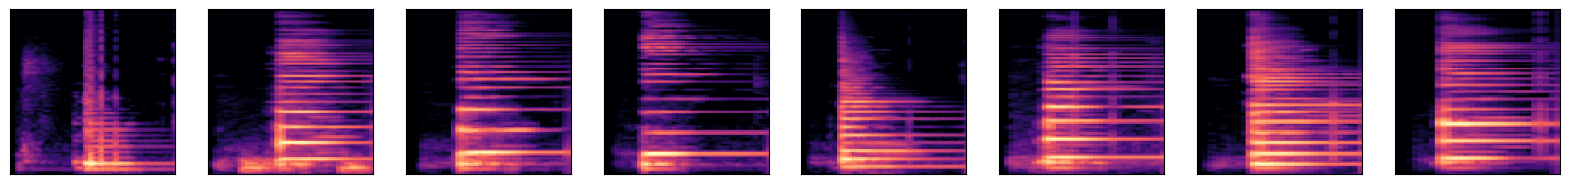

In [ ]:
# Visualizamos espectogramas aleatoriamente
import numpy as np
import random
import os
import pathlib
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
total_class_names = len(class_names)
class_key = random.randint(0, total_class_names)
show_images_from_path(train_dir + "/" + class_names[class_key], class_names[class_key])
print(class_names[class_key])

## 4. Preparar los datos con ImageDataGenerator

Genera lotes de datos de imágenes tensoriales con aumento de datos en tiempo real. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the data generators for training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


# Load spectrogram images
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary'
)

val_ds = val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary'
)

train_ds.class_indices

Found 1512 images belonging to 2 classes.
Found 175 images belonging to 2 classes.


{'chord': 0, 'note': 1}

## 5. Definir y entrenar el modelo CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
48/48 [==============================] - 7s 115ms/step - loss: 0.5898 - accuracy: 0.7295 - val_loss: 0.2781 - val_accuracy: 0.9143
Epoch 2/5
48/48 [==============================] - 5s 100ms/step - loss: 0.2720 - accuracy: 0.8909 - val_loss: 0.2223 - val_accuracy: 0.9143
Epoch 3/5
48/48 [==============================] - 5s 112ms/step - loss: 0.1012 - accuracy: 0.9663 - val_loss: 0.1179 - val_accuracy: 0.9771
Epoch 4/5
48/48 [==============================] - 5s 96ms/step - loss: 0.0578 - accuracy: 0.9795 - val_loss: 0.1387 - val_accuracy: 0.9657
Epoch 5/5
48/48 [==============================] - 5s 100ms/step - loss: 0.0272 - accuracy: 0.9921 - val_loss: 0.1220 - val_accuracy: 0.9600


## 6. Evaluar y Visualizar

Para evaluar nuestro modelo CNN de multi clasificación podriamos:
* Visualizar en gráficos la precisión y perdida del modelo.
* Realizar predicciones aleatorias y visualizar el resultado

In [ ]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {val_accuracy}")

6/6 [==============================] - 1s 78ms/step - loss: 0.1220 - accuracy: 0.9600
Validation accuracy: 0.9599999785423279


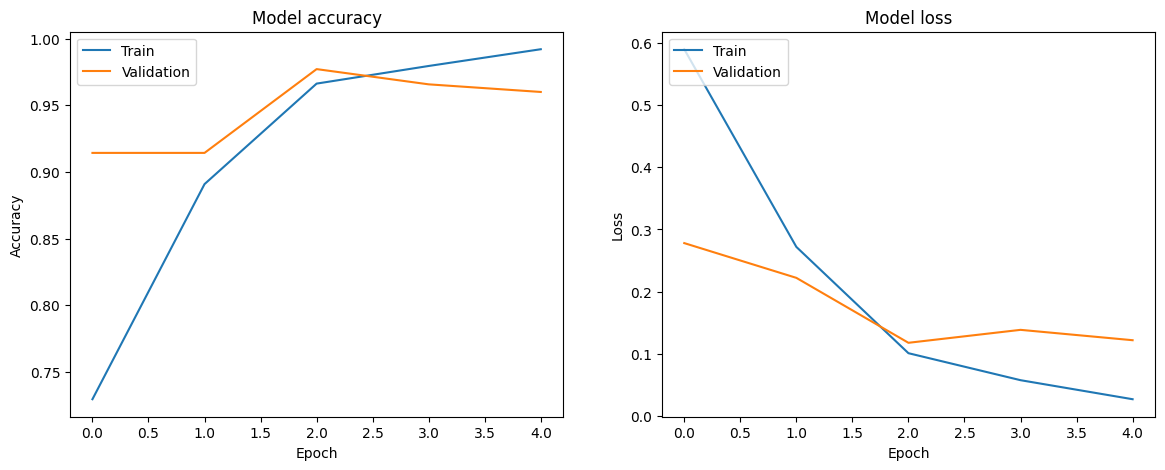

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## 7. Predicciones

Realizaremos predicciones aleatorias utilizando los espectogramas de la carpeta test grabados con la guitarra electroacústica.

In [ ]:
predictions = model.predict(val_ds)
predicted_classes = np.argmax(predictions, axis=1)
predictions, predicted_classes

6/6 [==============================] - 1s 72ms/step


(array([[2.3571962e-02],
        [9.9927908e-01],
        [7.8187889e-04],
        [9.7834146e-01],
        [7.4595311e-03],
        [9.9767047e-01],
        [9.9992275e-01],
        [2.4188779e-02],
        [8.7512463e-01],
        [2.3811678e-03],
        [9.1921723e-01],
        [7.7221694e-04],
        [9.9507117e-01],
        [9.8318958e-01],
        [9.9367589e-01],
        [9.1030133e-01],
        [2.2808730e-03],
        [4.0424656e-04],
        [9.9662697e-01],
        [9.9997938e-01],
        [9.9995196e-01],
        [2.0016324e-04],
        [9.9090832e-01],
        [2.1254276e-04],
        [9.9997318e-01],
        [9.9484622e-01],
        [1.1896901e-03],
        [1.4985727e-04],
        [9.9998808e-01],
        [9.9848610e-01],
        [9.9999344e-01],
        [1.6171101e-04],
        [1.0268424e-03],
        [9.9807477e-01],
        [1.8499735e-04],
        [2.1455768e-03],
        [9.7465408e-01],
        [9.9929762e-01],
        [9.9997783e-01],
        [9.9998093e-01],


1/1 [==============================] - 0s 19ms/step
[[3.5631776e-05]]
Random note path: ChordsVsNotesFull/test/note/EC5_50.mp3


1/1 [==============================] - 0s 28ms/step


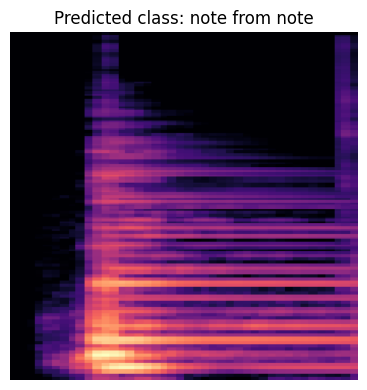

'note'

In [ ]:
total_class_names = 1
class_key = random.randint(0, total_class_names)
from keras.preprocessing import image
import matplotlib.pyplot as plt
from IPython.display import Audio, display
def predict_and_plot_from_wav_file2(wav_file_path, model, class_indices, class_to_predict, target_size=(224, 224)):
    # Invert the class_indices dictionary to map indices to class names
    index_to_class = {v: k for k, v in class_indices.items()}

    # Convert the .wav file to a spectrogram image
    create_spectrogram(wav_file_path, 'temp_spectrogram.png')

    # Display the sound player
    display(Audio(wav_file_path))

    # Load and preprocess the spectrogram image
    img = image.load_img('temp_spectrogram.png', target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    # Predict
    predictions = model.predict(img_array)
    predicted_class_index = int(np.round(predictions[0][0]))  # Assuming binary classification
    predicted_class_name = index_to_class[predicted_class_index]

    plt.figure(figsize=(10, 4))
    # Display spectrogram
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Predicted class: " + predicted_class_name + " from " + class_to_predict)
    plt.axis('off')


    plt.tight_layout()
    plt.show()

    return predicted_class_name

target_dir = "ChordVsNoteSpectograms/test/" + class_names[class_key]
img = image.load_img('temp_spectrogram.png', target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

# Predict
predictions = model.predict(img_array)
print(predictions)


target_dir = "ChordsVsNotesFull/test/" + class_names[class_key]
random_note = random.choice(os.listdir(target_dir))
random_note_path = target_dir + "/" + random_note

print("Random note path: " + random_note_path)
predict_and_plot_from_wav_file2(random_note_path, model, train_ds.class_indices,  class_names[class_key] )

## 8. Guardar y descargar modelo

In [ ]:
from google.colab import files
model.save("chordvsnote.h5")
files.download('chordvsnote.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>